<a href="https://colab.research.google.com/github/yuseongil034/yuseongil/blob/main/0710_opencv_.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [56]:
# 1.필요한 라이브러리 임포트
import cv2
import numpy as np
import matplotlib.pyplot as plt
from IPython.display import HTML, display
from google.colab.patches import cv2_imshow
import os

# 2. yt-dlp 설치
!pip install --upgrade yt-dlp

# 2. 간단한 다운로드로 시작
import yt_dlp # Moved import after installation
!yt-dlp -f bestvideo https://www.youtube.com/watch?v=tEtWnGwwCEc

[youtube] Extracting URL: https://www.youtube.com/watch?v=tEtWnGwwCEc
[youtube] tEtWnGwwCEc: Downloading webpage
[youtube] tEtWnGwwCEc: Downloading tv client config
[youtube] tEtWnGwwCEc: Downloading tv player API JSON
[youtube] tEtWnGwwCEc: Downloading ios player API JSON
[youtube] tEtWnGwwCEc: Downloading m3u8 information
[info] tEtWnGwwCEc: Downloading 1 format(s): 313
[download] Destination: 강남대로 강남역 도로 드라이브 최근 밤거리 모습 입니다. [tEtWnGwwCEc].webm
[download] 100% of  239.46MiB in 00:00:07 at 31.26MiB/s


/usr/local/lib/python3.11/dist-packages/IPython/core/pylabtools.py:151: UserWarning: Glyph 50896 (\N{HANGUL SYLLABLE WEON}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)
/usr/local/lib/python3.11/dist-packages/IPython/core/pylabtools.py:151: UserWarning: Glyph 48376 (\N{HANGUL SYLLABLE BON}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)
/usr/local/lib/python3.11/dist-packages/IPython/core/pylabtools.py:151: UserWarning: Glyph 54532 (\N{HANGUL SYLLABLE PEU}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)
/usr/local/lib/python3.11/dist-packages/IPython/core/pylabtools.py:151: UserWarning: Glyph 47112 (\N{HANGUL SYLLABLE RE}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)
/usr/local/lib/python3.11/dist-packages/IPython/core/pylabtools.py:151: UserWarning: Glyph 51076 (\N{HANGUL SYLLABLE IM}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)
/usr/l

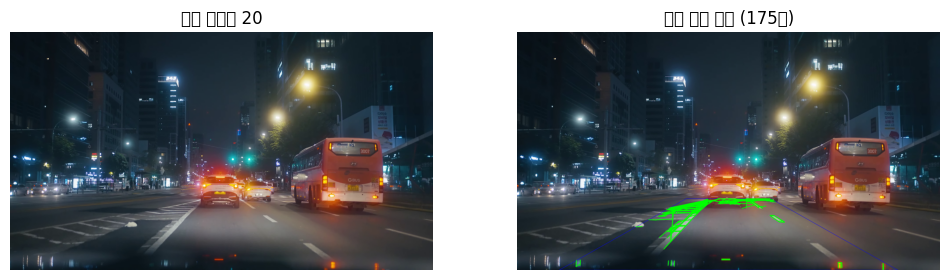


⏹️ 재생 중단
✅ 결과 영상 저장 완료: /content/lane_detection_result.mp4


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

📥 다운로드 시작!


In [51]:
import cv2
from google.colab import files
import matplotlib.pyplot as plt
import numpy as np
from IPython.display import clear_output
import time

# 영상 업로드
#uploaded = files.upload()
# Use the correct filename with .webm extension
video_path = "/content/강남대로 강남역 도로 드라이브 최근 밤거리 모습 입니다. [tEtWnGwwCEc].webm"

# 영상 열기
cap = cv2.VideoCapture(video_path)

# Check if video opened successfully
if not cap.isOpened():
    print(f"❌ Error: Could not open video file {video_path}")
else:
    fps = cap.get(cv2.CAP_PROP_FPS)
    frame_count = int(cap.get(cv2.CAP_PROP_FRAME_COUNT))

    # VideoWriter 설정 (누락된 부분 추가)
    output_path = "/content/lane_detection_result.mp4"
    width = int(cap.get(cv2.CAP_PROP_FRAME_WIDTH))
    height = int(cap.get(cv2.CAP_PROP_FRAME_HEIGHT))
    fourcc = cv2.VideoWriter_fourcc(*'mp4v')
    # Ensure the output video dimensions match the input
    out = cv2.VideoWriter(output_path, fourcc, fps, (width, height))
    print(f"💾 결과 영상 저장 경로: {output_path}")

    print(f"📹 영상 정보: {frame_count}프레임, {fps:.2f}FPS")
    print("🎬 차선 인식 시작! (Ctrl+C로 중단)")

    frame_num = 0
    try:
        while True:
            ret, frame = cap.read()
            if not ret:
                print("📺 영상 재생 완료")
                break

            # 1. 그레이스케일 변환
            gray = cv2.cvtColor(frame, cv2.COLOR_BGR2GRAY)

            # 2. 블러 → 에지(Canny) - 임계값 낮춤
            blur = cv2.GaussianBlur(gray, (5, 5), 0)
            edges = cv2.Canny(blur, 30, 100)  # 50,150 → 30,100

            # 3. ROI 설정 - 하단 30%
            # Use the frame's dimensions for ROI
            frame_height, frame_width = frame.shape[:2]
            mask = np.zeros((frame_height, frame_width), dtype=np.uint8)
            polygon = np.array([[
                (int(frame_width * 0.1), frame_height),            # 왼쪽 아래
                (int(frame_width * 0.9), frame_height),            # 오른쪽 아래
                (int(frame_width * 0.6), int(frame_height * 0.7)), # 오른쪽 위 (70% 지점)
                (int(frame_width * 0.4), int(frame_height * 0.7))  # 왼쪽 위 (70% 지점)
            ]])
            cv2.fillPoly(mask, polygon, 255)
            roi = cv2.bitwise_and(edges, mask)

            # 4. Hough Transform으로 직선 검출 - 파라미터 완화
            lines = cv2.HoughLinesP(roi, 2, np.pi / 180,
                                   threshold=30,      # 50 → 30
                                   minLineLength=30,  # 40 → 30
                                   maxLineGap=80)     # 50 → 80

            # 5. 원본 프레임에 선 그리기
            line_image = frame.copy()
            # ROI 영역을 화면에 표시 (사다리꼴 테두리)
            roi_points_display = np.array([
                [int(frame_width * 0.1), frame_height],
                [int(frame_width * 0.9), frame_height],
                [int(frame_width * 0.6), int(frame_height * 0.7)],
                [int(frame_width * 0.4), int(frame_height * 0.7)]
            ], np.int32)
            cv2.polylines(line_image, [roi_points_display], isClosed=True, color=(255, 0, 0), thickness=2)


            if lines is not None:
                for line in lines:
                    x1, y1, x2, y2 = line[0]
                    cv2.line(line_image, (x1, y1), (x2, y2), (0, 255, 0), 5)

            # 결과 프레임을 영상 파일에 저장
            if out.isOpened(): # Check if VideoWriter is opened
                out.write(line_image)

            # 6. 결과 출력 (매 10프레임마다만 출력하여 속도 개선)
            if frame_num % 10 == 0:  # 10프레임마다만 출력
                clear_output(wait=True)
                plt.figure(figsize=(12, 6))
                plt.subplot(1, 2, 1)
                plt.imshow(cv2.cvtColor(frame, cv2.COLOR_BGR2RGB))
                plt.title(f"원본 프레임 {frame_num}")
                plt.axis('off')

                plt.subplot(1, 2, 2)
                plt.imshow(cv2.cvtColor(line_image, cv2.COLOR_BGR2RGB))
                plt.title(f"차선 인식 결과 ({len(lines) if lines is not None else 0}개)")
                plt.axis('off')
                plt.show()

            frame_num += 1
            # time.sleep 제거 (속도 개선)

    except KeyboardInterrupt:
        print("\n⏹️ 재생 중단")

    # 리소스 정리
    cap.release()
    if out.isOpened(): # Check if VideoWriter is opened before releasing
        out.release()
    cv2.destroyAllWindows()

    print(f"✅ 결과 영상 저장 완료: {output_path}")

    # 파일 다운로드
    files.download(output_path)
    print("📥 다운로드 시작!")

차선 인식 영상 처리 코드에 중간 처리 단계 시각화(에지, ROI 마스크, ROI 적용 에지 등) subplot 코드를 추가

In [58]:
import cv2
from google.colab import files
import matplotlib.pyplot as plt
import numpy as np
from IPython.display import clear_output
import time

# 영상 업로드
#uploaded = files.upload()
video_path = "/content/강남대로 강남역 도로 드라이브 최근 밤거리 모습 입니다. [tEtWnGwwCEc].webm"

cap = cv2.VideoCapture(video_path)

if not cap.isOpened():
    print(f"❌ Error: Could not open video file {video_path}")
else:
    fps = cap.get(cv2.CAP_PROP_FPS)
    frame_count = int(cap.get(cv2.CAP_PROP_FRAME_COUNT))
    output_path = "/content/lane_detection_result.mp4"
    width = int(cap.get(cv2.CAP_PROP_FRAME_WIDTH))
    height = int(cap.get(cv2.CAP_PROP_FRAME_HEIGHT))
    fourcc = cv2.VideoWriter_fourcc(*'mp4v')
    out = cv2.VideoWriter(output_path, fourcc, fps, (width, height))
    print(f"💾 결과 영상 저장 경로: {output_path}")
    print(f"📹 영상 정보: {frame_count}프레임, {fps:.2f}FPS")
    print("🎬 차선 인식 시작! (Ctrl+C로 중단)")

    frame_num = 0
    try:
        while True:
            ret, frame = cap.read()
            if not ret:
                print("📺 영상 재생 완료")
                break

            # 1. 그레이스케일 변환
            gray = cv2.cvtColor(frame, cv2.COLOR_BGR2GRAY)

            # 2. 블러 → 에지(Canny) - 임계값 낮춤
            blur = cv2.GaussianBlur(gray, (5, 5), 0)
            edges = cv2.Canny(blur, 30, 100)

            # 3. ROI 설정 - 하단 30%
            frame_height, frame_width = frame.shape[:2]
            mask = np.zeros((frame_height, frame_width), dtype=np.uint8)
            polygon = np.array([[
                (int(frame_width * 0.1), frame_height),
                (int(frame_width * 0.9), frame_height),
                (int(frame_width * 0.6), int(frame_height * 0.7)),
                (int(frame_width * 0.4), int(frame_height * 0.7))
            ]])
            cv2.fillPoly(mask, polygon, 255)
            roi = cv2.bitwise_and(edges, mask)

            # 4. Hough Transform으로 직선 검출 - 파라미터 완화
            lines = cv2.HoughLinesP(roi, 2, np.pi / 180,
                                   threshold=30,
                                   minLineLength=30,
                                   maxLineGap=80)

            # 5. 원본 프레임에 선 그리기
            line_image = frame.copy()
            roi_points_display = np.array([
                [int(frame_width * 0.1), frame_height],
                [int(frame_width * 0.9), frame_height],
                [int(frame_width * 0.6), int(frame_height * 0.7)],
                [int(frame_width * 0.4), int(frame_height * 0.7)]
            ], np.int32)
            cv2.polylines(line_image, [roi_points_display], isClosed=True, color=(255, 0, 0), thickness=2)

            if lines is not None:
                for line in lines:
                    x1, y1, x2, y2 = line[0]
                    cv2.line(line_image, (x1, y1), (x2, y2), (0, 255, 0), 5)

            # 결과 프레임을 영상 파일에 저장
            if out.isOpened():
                out.write(line_image)

            # 6. 결과 및 중간 처리 단계 시각화 (매 10프레임마다)
            if frame_num % 10 == 0:
                clear_output(wait=True)
                plt.figure(figsize=(18, 8))
                # 1. 원본
                plt.subplot(2, 4, 1)
                plt.imshow(cv2.cvtColor(frame, cv2.COLOR_BGR2RGB))
                plt.title(f"원본 프레임 {frame_num}")
                plt.axis('off')
                # 2. 그레이스케일
                plt.subplot(2, 4, 2)
                plt.imshow(gray, cmap='gray')
                plt.title("Grayscale")
                plt.axis('off')
                # 3. 에지 검출 (전체)
                plt.subplot(2, 4, 3)
                plt.imshow(edges, cmap='gray')
                plt.title("total edge detection")
                plt.axis('off')
                # 4. ROI 마스크
                plt.subplot(2, 4, 4)
                plt.imshow(mask, cmap='gray')
                plt.title("ROI mask")
                plt.axis('off')
                # 5. ROI 적용된 에지
                plt.subplot(2, 4, 5)
                plt.imshow(roi, cmap='gray')
                plt.title("ROI after edge")
                plt.axis('off')
                # 6. 차선 인식 결과
                plt.subplot(2, 4, 6)
                plt.imshow(cv2.cvtColor(line_image, cv2.COLOR_BGR2RGB))
                plt.title(f"차선 인식 결과 ({len(lines) if lines is not None else 0}개)")
                plt.axis('off')
                plt.tight_layout()
                plt.show()

            frame_num += 1

    except KeyboardInterrupt:
        print("\n⏹️ 재생 중단")

    cap.release()
    if out.isOpened():
        out.release()
    cv2.destroyAllWindows()
    print(f"✅ 결과 영상 저장 완료: {output_path}")
    files.download(output_path)
    print("📥 다운로드 시작!")


/tmp/ipython-input-58-1695062631.py:114: UserWarning: Glyph 50896 (\N{HANGUL SYLLABLE WEON}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
/tmp/ipython-input-58-1695062631.py:114: UserWarning: Glyph 48376 (\N{HANGUL SYLLABLE BON}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
/tmp/ipython-input-58-1695062631.py:114: UserWarning: Glyph 54532 (\N{HANGUL SYLLABLE PEU}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
/tmp/ipython-input-58-1695062631.py:114: UserWarning: Glyph 47112 (\N{HANGUL SYLLABLE RE}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
/tmp/ipython-input-58-1695062631.py:114: UserWarning: Glyph 51076 (\N{HANGUL SYLLABLE IM}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
/tmp/ipython-input-58-1695062631.py:114: UserWarning: Glyph 52264 (\N{HANGUL SYLLABLE CA}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
/tmp/ipython-input-58-1695062631.py:114: UserWarning: Glyph 49440 (\N{HANGUL SYLLABLE SEON}) missing from font(s) DejaVu


⏹️ 재생 중단
✅ 결과 영상 저장 완료: /content/lane_detection_result.mp4


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

📥 다운로드 시작!
